<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#第一種の過誤の確率の比較" data-toc-modified-id="第一種の過誤の確率の比較-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>第一種の過誤の確率の比較</a></span></li><li><span><a href="#パワーの比較" data-toc-modified-id="パワーの比較-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>パワーの比較</a></span></li></ul></div>

In [1]:
using Printf

using Distributions
using Roots
using StatsBase: ecdf
using StatsFuns
using StatsPlots
default(fmt=:png, size=(500, 300),
    titlefontsize=10, tickfontsize=6, guidefontsize=9,
    plot_titlefontsize=10)

safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y
x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

In [2]:
# odds ratio Wald

oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
stderr_logoddsratiohat(a, b, c, d) = √(1/a + 1/b + 1/c + 1/d)

function pvalue_or_wald(a, b, c, d; ω=1)
    logORhat = log(oddsratiohat(a, b, c, d))
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logORhat - log(ω)), SEhat_logORhat))
end

function confint_or_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    ORhat = oddsratiohat(a, b, c, d)
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logORhat), ORhat), safemul(exp(z*SEhat_logORhat), ORhat)]
end

confint_or_wald (generic function with 1 method)

In [3]:
# risk ratio Wald

riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
stderr_logriskratiohat(a, b, c, d) = √(1/a - 1/(a+b) + 1/c - 1/(c+d))

function pvalue_rr_wald(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function confint_rr_wald(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0) && return [0, Inf]
    z = quantile(Normal(), 1-α/2)
    RRhat = riskratiohat(a, b, c, d)
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logRRhat), RRhat), safemul(exp(z*SEhat_logRRhat), RRhat)]
end

confint_rr_wald (generic function with 1 method)

In [4]:
# odds ration Pearson's χ²

function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? typeof(ω)(-min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [5]:
function Delta(a, b, c, d; ρ=1)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    isinf(ρ) ? typeof(ω)(-c) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    RRhat = riskratiohat(a, b, c, d)
    if a == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif c == 0
        [exp(find_zero(f, 0.0)), Inf]
    elseif b == 0
        [0.0, exp(find_zero(f, log(2RRhat)))]
    elseif d == 0
        [exp(find_zero(f, log(RRhat/2))), Inf]
    else
        ρ_L, ρ_U = RRhat/2, 2RRhat
        [exp(find_zero(f, log(ρ_L))), exp(find_zero(f, log(ρ_U)))]
    end
end

confint_rr_pearson_chisq (generic function with 1 method)

In [6]:
# risk ratio Pearson's χ²

function pvalue_or_fisher_cp(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    min(1, 2cdf(fnch, a), 2ccdf(fnch, a-1))
end

function confint_or_fisher_cp(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(ω) = logit(pvalue_or_fisher_cp(a, b, c, d; ω)) - logit(α)
    if a == 0 || d == 0
        [0.0, find_zero(f, 1.0)]
    elseif b == 0 || c == 0
        [find_zero(f, 1.0), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        find_zeros(f, ω_L, ω_U)
    end
end

confint_or_fisher_cp (generic function with 1 method)

In [7]:
_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_sterne(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_or_fisher_sterne(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    pvalue_sterne(fnch, a)
end

function confint_or_fisher_sterne(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_fisher_sterne(a, b, c, d; ω=exp(logω))) - logit(α)
    if a == 0 || d == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        ps = exp.(find_zeros(f, log(ω_L), log(ω_U)))
        # 次の行は稀に区間にならない場合への対策
        [first(ps), last(ps)]
    end
end

confint_or_fisher_sterne (generic function with 1 method)

In [8]:
function plot_cdfpvals(m, n, q, p=q; L = 10^6, kwargs...)
    bin1 = Binomial(m, p)
    bin2 = Binomial(n, q)
    pval1 = Vector{Float64}(undef, L)
    pval2 = Vector{Float64}(undef, L)
    pval3 = Vector{Float64}(undef, L)
    pval4 = Vector{Float64}(undef, L)
    Threads.@threads for i in 1:L
        a, c = rand(bin1), rand(bin2)
        b, d = m-a, n-c
        pval1[i] = pvalue_or_pearson_chisq(a, b, c, d)
        pval2[i] = pvalue_or_wald(a, b, c, d)
        pval3[i] = pvalue_or_fisher_sterne(a, b, c, d)
        pval4[i] = pvalue_or_fisher_cp(a, b, c, d)
    end
    ecdf1 = ecdf(pval1)
    ecdf2 = ecdf(pval2)
    ecdf3 = ecdf(pval3)
    ecdf4 = ecdf(pval4)
    f1(x) = ecdf1(x)
    f2(x) = ecdf2(x)
    f3(x) = ecdf3(x)
    f4(x) = ecdf4(x)
    name1 = "Pearson χ²"
    name2 = "Wald"
    name3 = "Fisher (Sterne)"
    name4 = "Fisher (CP)"

    P1 = plot(legend=:topleft)
    plot!(f1, 0, 1; label=name1)
    plot!(f2, 0, 1; label=name2, ls=:dash)
    plot!(f3, 0, 1; label=name3, ls=:dashdot)
    plot!(f4, 0, 1; label=name4, ls=:dot, lw=1.2)
    plot!([0,1], [0,1]; label="", c=:black, ls=:dot, lw=0.5)
    plot!(xtick=0:0.1:1, ytick=0:0.1:1)
    plot!(xguide="α", yguide="probability of P-value ≤ α")

    P2 = plot(legend=:topleft)
    plot!(f1, 0, 0.1; label=name1)
    plot!(f2, 0, 0.1; label=name2, ls=:dash)
    plot!(f3, 0, 0.1; label=name3, ls=:dashdot)
    plot!(f4, 0, 0.1; label=name4, ls=:dot, lw=1.2)
    plot!([0,0.1], [0,0.1]; label="", c=:black, ls=:dot, lw=0.5)
    plot!(xtick=0:0.01:1,
        ytick=f1(0.1)<0.1 ? (0:0.01:1) : f1(0.1)<0.5 ? (0:0.05:1) : (0:0.1:1))
    plot!(xguide="α", yguide="probability of P-value ≤ α")

    p_str = @sprintf("%.3f", p)
    q_str = @sprintf("%.3f", q)
    plot(P1, P2; size=(640, 340))
    plot!(plot_title="Assumption: data is generated by Bin($m, $p_str)×Bin($n, $q_str)")
    plot!(; kwargs...)
end

function plot_cdfpvals_or(m, n, q, ω = 1; L = 10^6, kwargs...)
    p = logistic(log(ω) + logit(q))
    plot_cdfpvals(m, n, q, p; L, legend=:bottomright, kwargs...)
end

plot_cdfpvals_or (generic function with 2 methods)

## 第一種の過誤の確率の比較

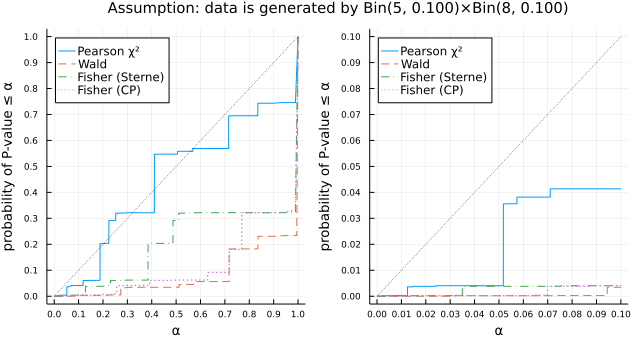

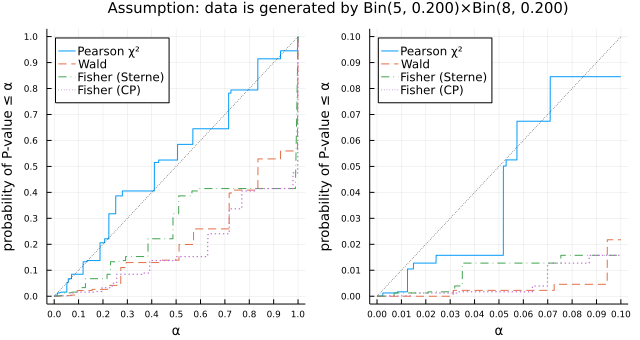

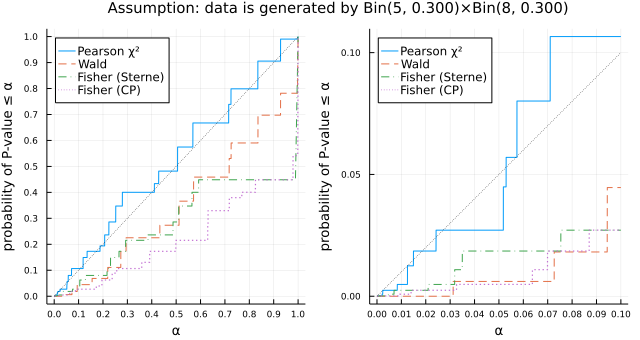

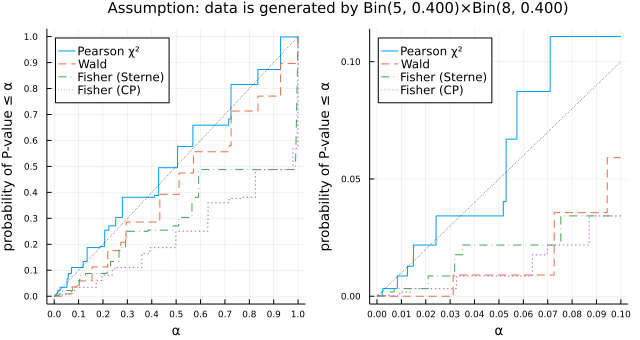

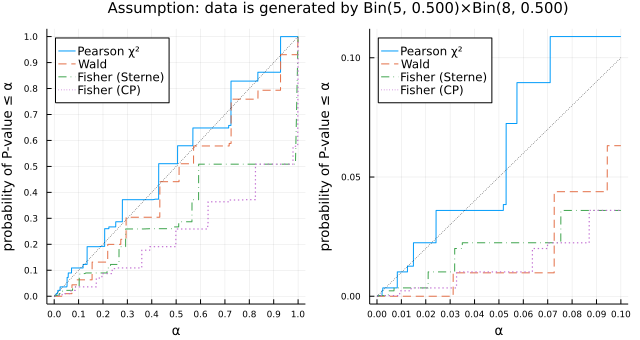

In [9]:
for q in 0.1:0.1:0.5
    plot_cdfpvals(5, 8, q) |> display
end

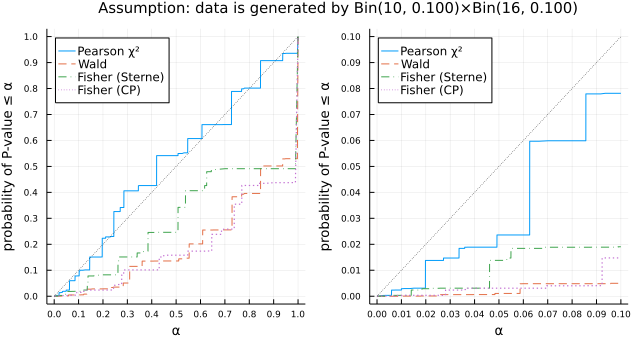

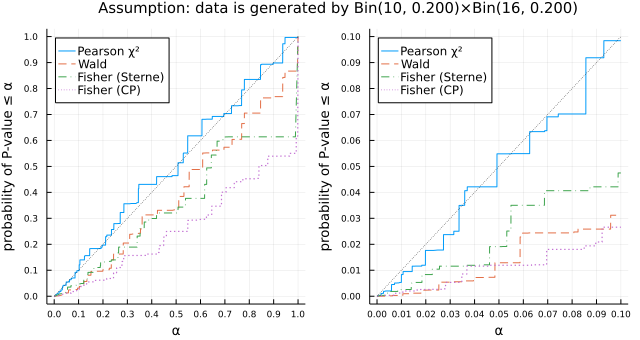

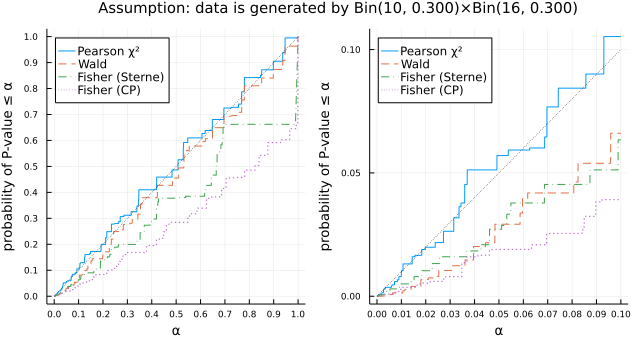

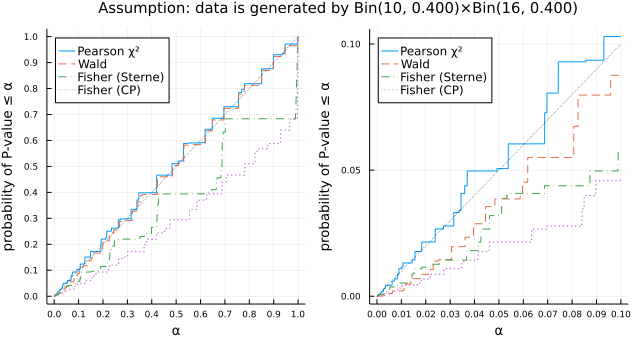

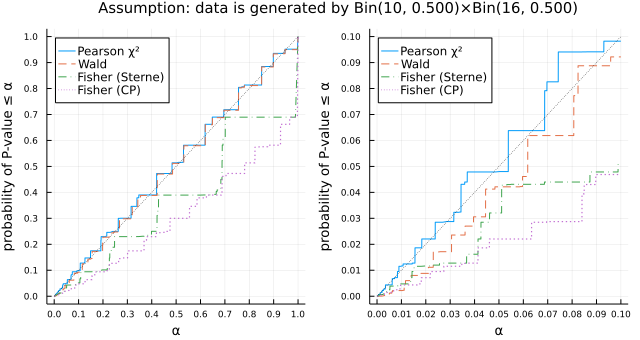

In [10]:
for q in 0.1:0.1:0.5
    plot_cdfpvals(10, 16, q) |> display
end

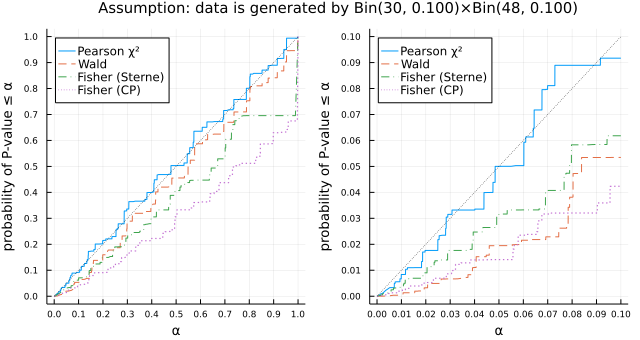

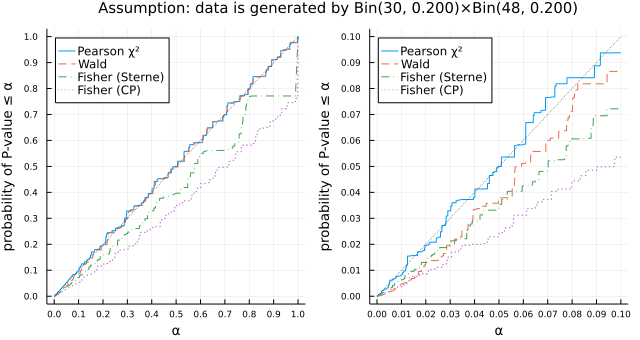

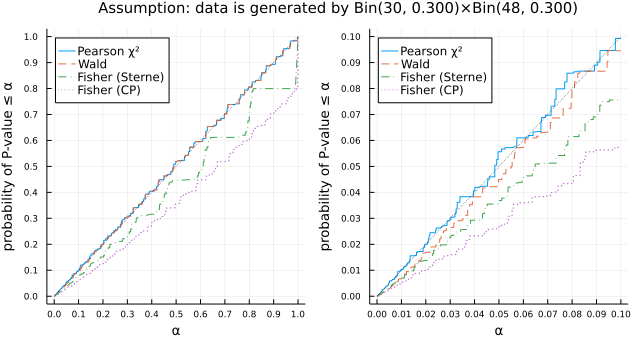

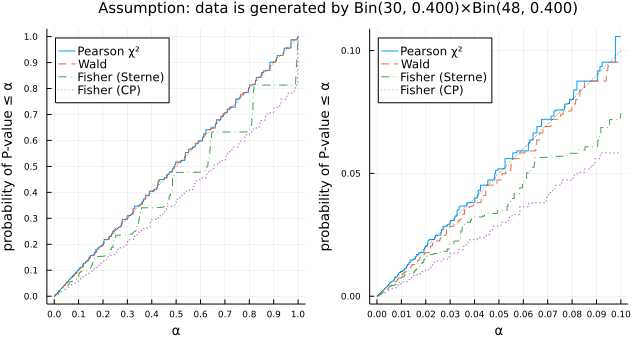

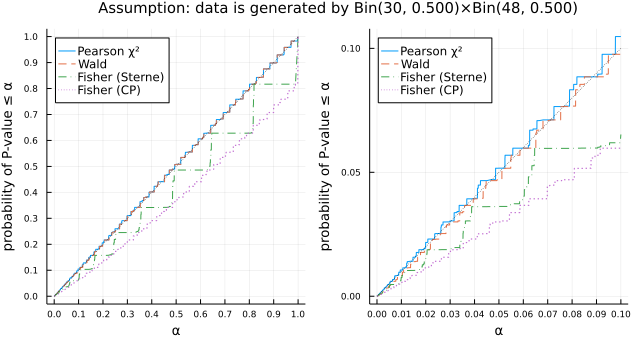

In [11]:
for q in 0.1:0.1:0.5
    plot_cdfpvals(30, 48, q) |> display
end

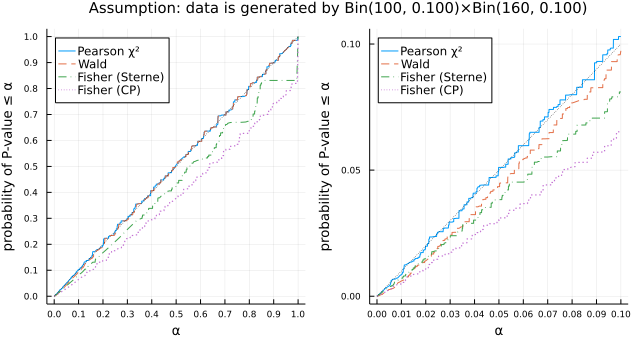

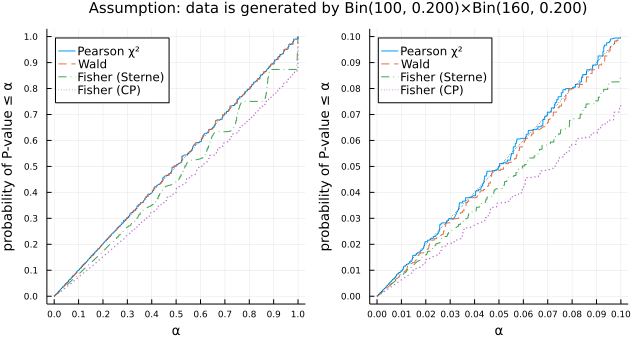

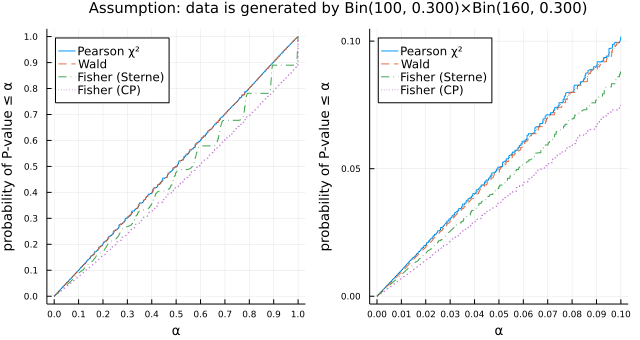

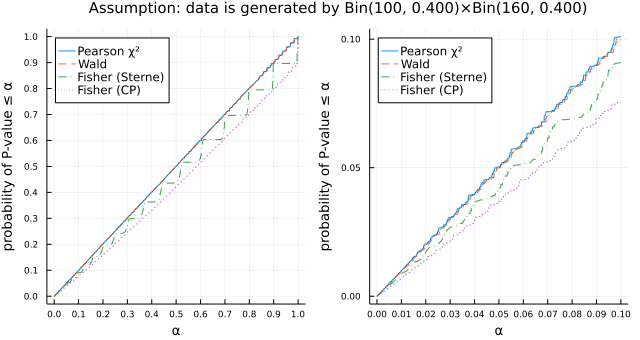

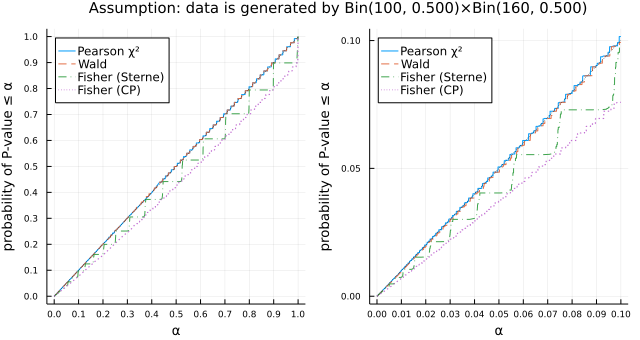

In [12]:
for q in 0.1:0.1:0.5
    plot_cdfpvals(100, 160, q) |> display
end

## パワーの比較

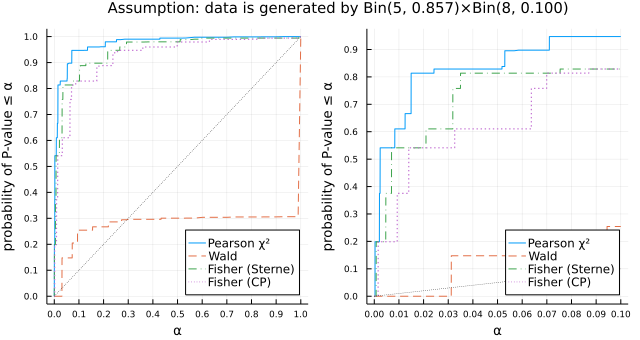

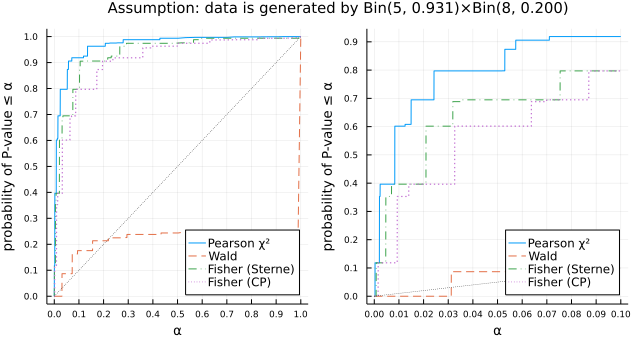

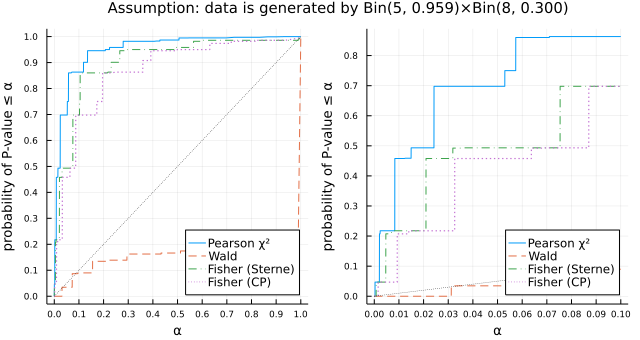

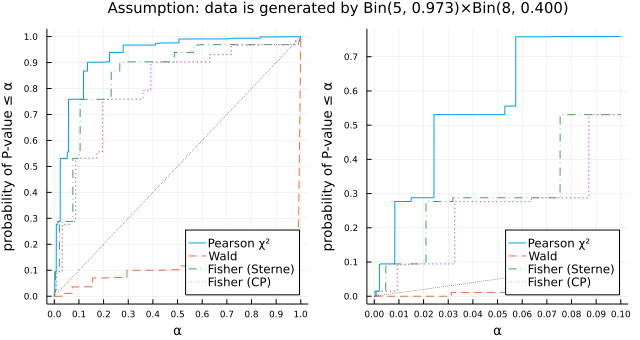

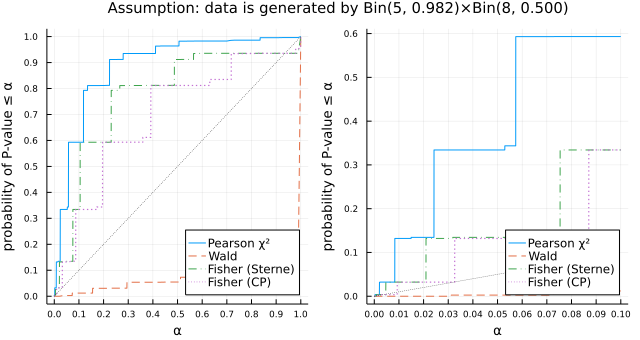

In [13]:
for q in 0.1:0.1:0.5
    plot_cdfpvals_or(5, 8, q, 54) |> display
end

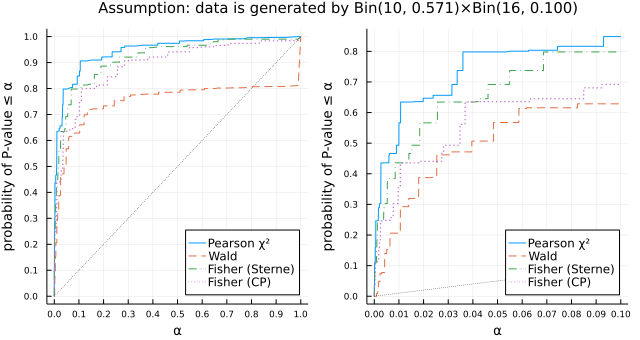

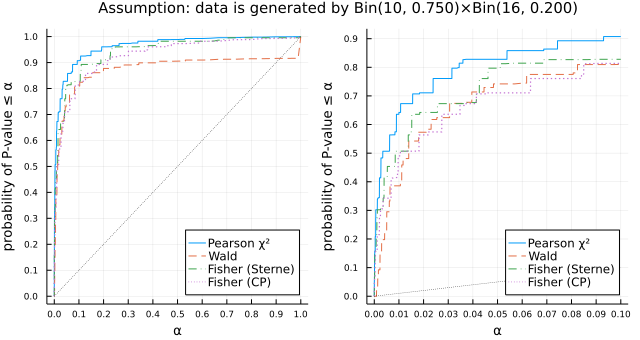

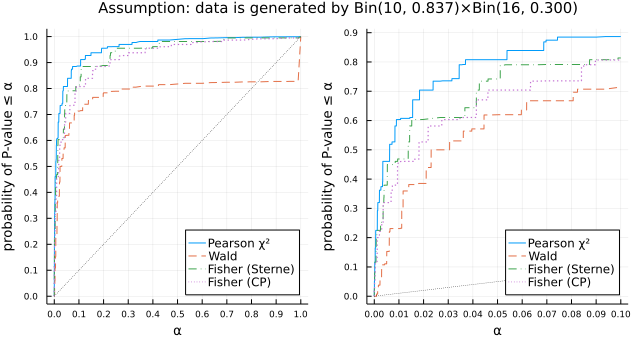

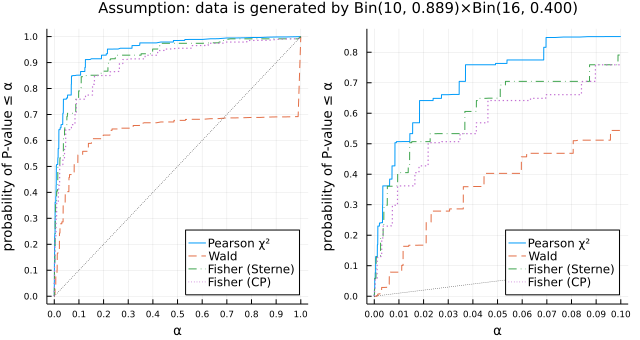

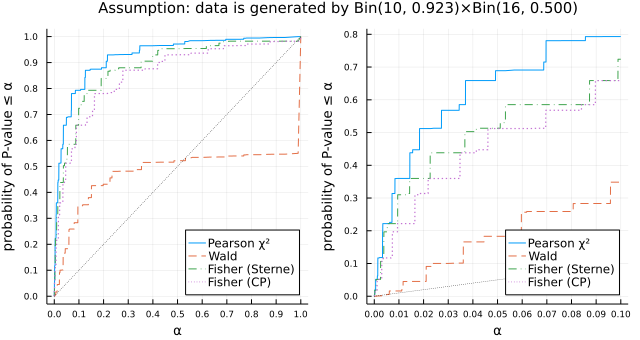

In [14]:
for q in 0.1:0.1:0.5
    plot_cdfpvals_or(10, 16, q, 12) |> display
end

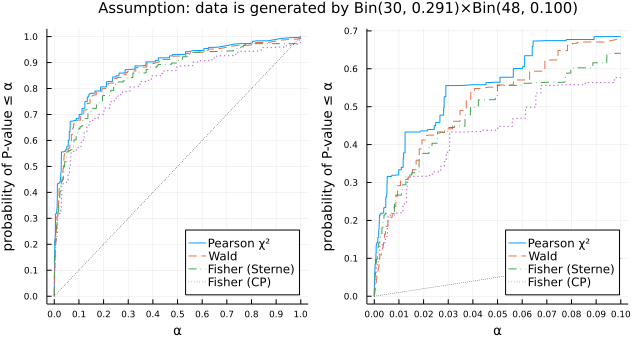

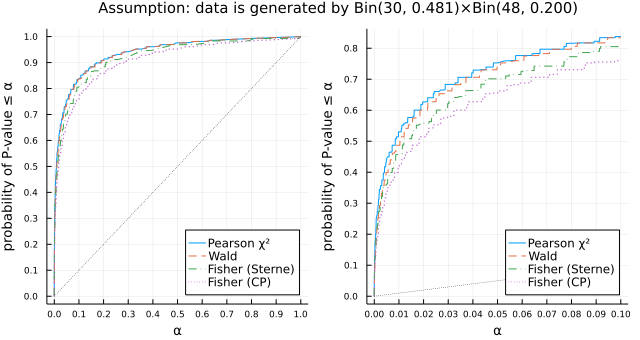

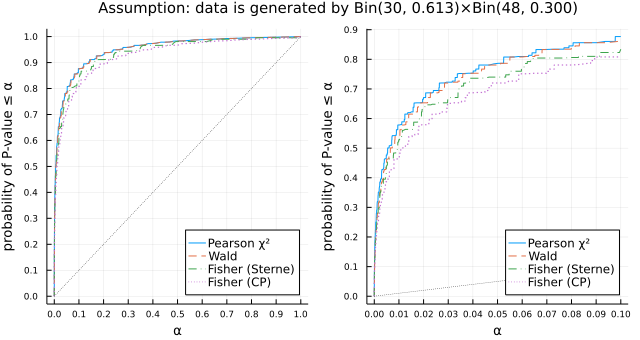

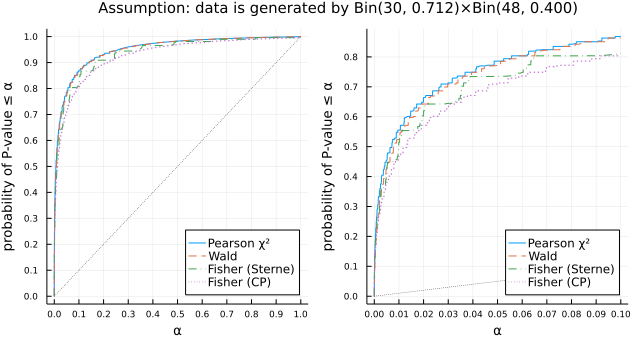

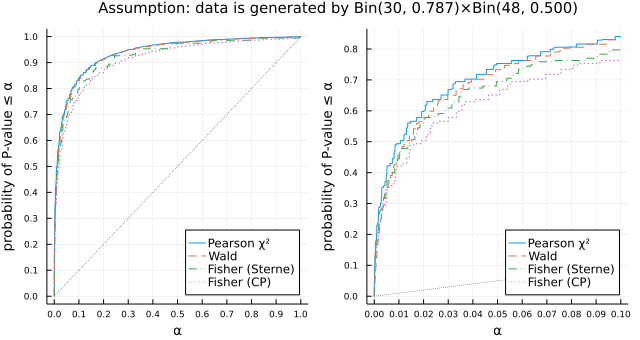

In [15]:
for q in 0.1:0.1:0.5
    plot_cdfpvals_or(30, 48, q, 3.7) |> display
end

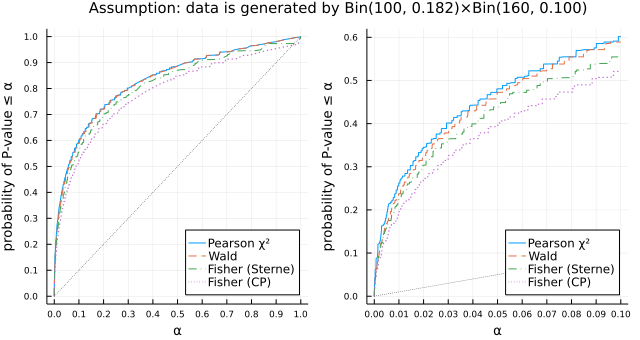

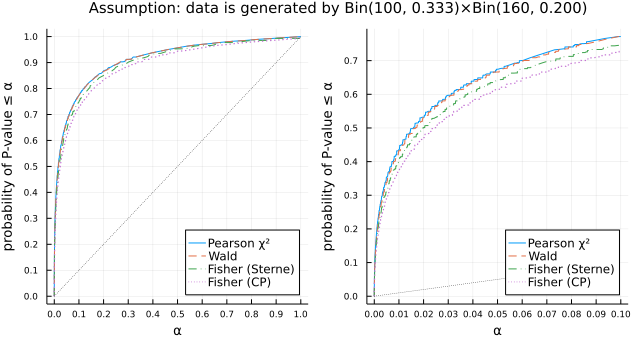

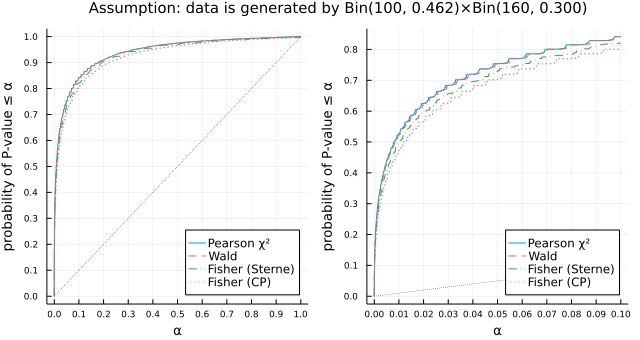

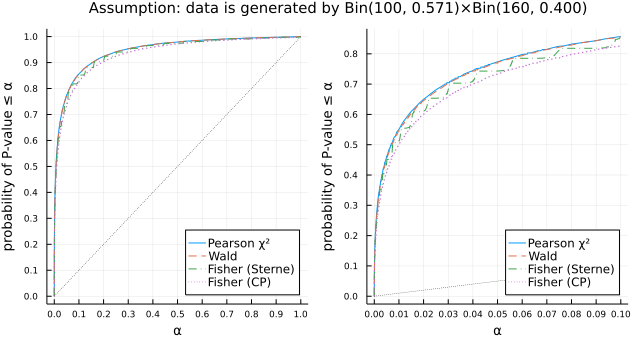

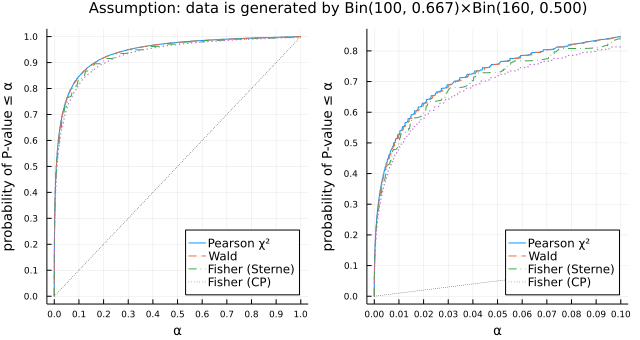

In [16]:
for q in 0.1:0.1:0.5
    plot_cdfpvals_or(100, 160, q, 2.0) |> display
end